In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

# Read Data
* Data Descriptions: https://www.kaggle.com/c/titanic/data

In [55]:
# 본인의 환경에 맞게 경로 설정 해주세요.
train = pd.read_csv('Data/titanic/train.csv')
test = pd.read_csv('Data/titanic/test.csv')

In [56]:
train.sample()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
627,628,1,1,"Longley, Miss. Gretchen Fiske",female,21.0,0,0,13502,77.9583,D9,S


## Check null values

In [57]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [58]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

# EDA
어떤 feature가 Survived 컬럼을 유의미하게 설명하는지 분석해보세요.

In [59]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


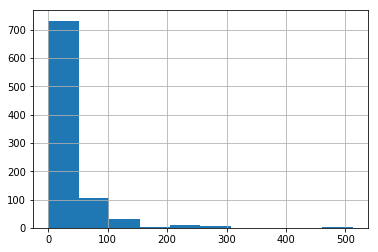

In [60]:
train['Fare'].hist()

# Concat Data

In [61]:
train_except_Survived = train.drop('Survived', axis=1)

In [62]:
train_except_Survived['tag'] = 'train'
test['tag'] = 'test'

In [63]:
df = pd.concat([train_except_Survived, test])

## 컬럼 다루기
### Categorical
- 순서가 있는 것
> ex. Pclass
- 순서가 없는 것: One-Hot Encoding 
> ex. Embarked

### Number
- Float 실수형
- integer 정수형

### Sex(Categorical)

In [64]:
df['Female'] = df['Sex'].apply(lambda x: x.lower()) == 'female'

df[['Sex', 'Female']].sample()

,Sex,Female
876,male,False


### Embarked(Categorical) 
One Hot Encoding

In [15]:
# train.Embarked.unique()

In [68]:
df['Embarked'] = df['Embarked'].fillna('S')

In [69]:
df['Embarked_C'] = df['Embarked'] == 'C'
df['Embarked_Q'] = df['Embarked'] == 'Q'

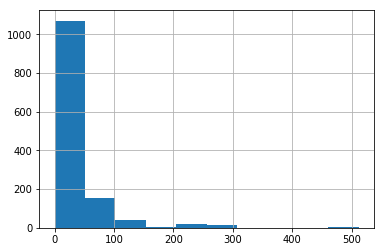

In [70]:
df['Fare'].hist()

In [71]:
df = df[df['Fare']<400]

# Feature Engineering

### Family Size
Parch + Sibsp + 1

In [72]:
df['Family'] = df['SibSp'] + df['Parch'] + 1

df[['SibSp', 'Parch', 'Family']].sample()

,SibSp,Parch,Family
261,0,0,1


# Null 값 처리

### Age
Sex, Pclass 별 Median 값

In [79]:
df['Age'].isnull().sum()

263

In [84]:
df.groupby(['Female', 'Pclass']).median()['Age']

Female  Pclass
False   1         42.0
        2         29.5
        3         25.0
True    1         36.0
        2         28.0
        3         22.0
Name: Age, dtype: float64

In [91]:
df = df.set_index('PassengerId')

In [92]:
df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

### Fare

In [80]:
df[df['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,tag,Female,Embarked_C,Embarked_Q,Family


In [82]:
df.groupby(['Pclass', 'Parch']).Fare.median()
# [3][0]

Pclass  Parch
1       0         52.00000
        1         79.65000
        2        134.50000
        3        262.37500
        4        263.00000
2       0         13.00000
        1         26.00000
        2         30.00000
        3         23.00000
3       0          7.89580
        1         15.90000
        2         27.90000
        3         34.37500
        4         26.68335
        5         31.33125
        6         46.90000
        9         69.55000
Name: Fare, dtype: float64

In [93]:
fare = df.groupby(['Pclass', 'Parch']).Fare.median()[3][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df['Fare'] = df['Fare'].fillna(fare)

In [94]:
df.shape

(1304, 15)

In [95]:
df.isnull().sum()

Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin         1012
Embarked         0
tag              0
Female           0
Embarked_C       0
Embarked_Q       0
Family           0
dtype: int64

In [96]:
df.drop(columns='Cabin')

df.sample()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,tag,Female,Embarked_C,Embarked_Q,Family
PassengerId,,,,,,,,,,,,,,,
197,3,"Mernagh, Mr. Robert",male,25.0,0,0,368703,7.75,NaN,Q,train,False,False,True,1


# Make dataset for model fitting

independents|dependent
-|-
독립변수|종속변수
$X$|$y$

- $X$ 대문자: Metrix
- $y$ 소문자: Vetor

In [97]:
df.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'tag', 'Female', 'Embarked_C', 'Embarked_Q',
       'Family'],
      dtype='object')

In [32]:
# choose independent variables(Xs) which are useful!
# 트레이닝에 사용할 변수 목록을 적어주세요.
independents = ['Age',  'Parch', 'Pclass', 'Sex', 'SibSp'] 
dependent = ['Survived'] 

In [33]:
# 적어준 변수 목록을 사용해 데이터를 트레이닝에 맞는 포맷으로 변경합니다.
train_X = df[df['tag'] == 'train'][independents]
train_y = train[dependent]

test_X = df[df['tag'] == 'test'][independents]

# Model fitting

In [34]:
# 학습 fit()
reg = LinearRegression().fit(train_X, train_y)
# 대문자는 매트릭스, 소문자는 벡터

ValueError: could not convert string to float: 'male'

In [35]:
# x 계수
# x 계수의 의미를 해석하세요.
reg.coef_

NameError: name 'reg' is not defined

In [36]:
# 절편
reg.intercept_

NameError: name 'reg' is not defined

In [37]:
# R-squared
reg.score(train_X, train_y, sample_weight=None) # 11% 설명한다.

NameError: name 'reg' is not defined

In [38]:
temp.sample()

NameError: name 'temp' is not defined

In [39]:
temp = df[df['tag'] == 'train'].reset_index()
# temp.head()
temp = temp.merge(train[['PassengerId', 'Survived']], how='inner', on='PassengerId')

In [40]:
res = glm('Survived ~ Age + Pclass +Sex+ SibSp'
       , temp, family=Binomial()).fit() 

NameError: name 'glm' is not defined

In [133]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      886
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -392.44
Date:                Mon, 14 Oct 2019   Deviance:                       784.89
Time:                        16:24:39   Pearson chi2:                     939.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8801      0.467      6.166      0.000       1.965       3.796
Age           -0.0455      0.008     -5.590      0.000      -0.061      -0.030
Pclass        -1.2874      0.129     -9.986      0.000      -1.540      -1.035
Sex            2.7147      0.195     13.929      0.000       2.333       3.097
SibSp         -0.3793      0.105     -3.625      0.000      -0.584      -0.174
==============================================================================
"""

In [192]:
df.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Ticket', 'family', 'tag'],
      dtype='object')

In [135]:
from statsmodels.formula.api import ols

In [149]:
res = ols('Survived ~ Age + Pclass + Sex + SibSp + Parch'
       , temp).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Survived   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     116.1
Date:                Mon, 14 Oct 2019   Prob (F-statistic):           2.52e-94
Time:                        16:32:02   Log-Likelihood:                -394.44
No. Observations:                 888   AIC:                             800.9
Df Residuals:                     882   BIC:                             829.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8689      0.065     13.269      0.000       0.740       0.997
Age           -0.0065      0.001     -5.925      0.000      -0.009      -0.004
Pclass        -0.1943      0.017    -11.363      0.000      -0.228      -0.161
Sex            0.5098      0.028     18.224      0.000       0.455       0.565
SibSp         -0.0428      0.013     -3.316      0.001      -0.068      -0.017
Parch         -0.0161      0.018     -0.904      0.366      -0.051       0.019
==============================================================================
Omnibus:                       39.632   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.869
Skew:                           0.539   Prob(JB):                     2.98e-10
Kurtosis:                       3.156   Cond. No.                         171.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Prediction
실수로 나오는 예측값을 0/1로 변경

In [156]:
prediction = res.predict(test_X)

In [159]:
# 회귀 예측 결과를 classification으로 바꿔주기
# 여기에서는 회귀 예측 결과가 0.5 이상일 때에는 1, 그렇지 않으면 0으로 바꿔줬습니다.
prediction_binomial = [1 if p>=0.5 else 0 for p in prediction]


In [168]:
df = pd.DataFrame({'prediction': [p[0] for p in prediction],
                   'prediction_binomial': prediction_binomial})

In [169]:
df.sample()

,prediction_binomial
269,0


# Submission

In [170]:
submission = pd.read_csv('Data/titanic/gender_submission.csv')

In [171]:
submission['Survived'] = df['prediction_binomial']

In [173]:
submission.to_csv('./submission.csv', index=False)

# Rules
* 주어진 시간을 준수해주세요. Kaggle 제출과 채점까지 마친 상태여야 합니다.
* 모방은 창조의 어머니! 먼저 데이터를 분석해본 분석가들의 노트북을 보고 따라하세요.
* 새롭게 배우게 된 지식을 동료와 공유하세요.

# Hint
1. Logistic Regression으로도 풀어보세요. (이외에 다른 모델 사용 가능)
2. null 값이 있는 컬럼을 사용한다면, 현명하게 채워보세요.
3. Sex 컬럼을 regression에 넣을 수 있는 형태로 변형하세요.
4. 기존 데이터를 사용해 새로운 의미있는 변수를 만들어보세요. (캐글에 다른 노트북들을 참고하세요.)
    ### 참고해볼만한 노트북:
    * https://www.kaggle.com/gunesevitan/advanced-feature-engineering-tutorial-with-titanic
    * https://www.kaggle.com/ash316/eda-to-prediction-dietanic

# 로지스틱 회귀?
* https://ratsgo.github.io/machine%20learning/2017/04/02/logistic/
* https://ratsgo.github.io/machine%20learning/2017/07/02/logistic/

# Desicion Tree 2019-11-04

In [2]:
from sklearn.tree import DecisionTreeClassifier

# Random Forest

In [98]:
from sklearn.ensemble import RandomForestClassifier

In [99]:
forest = RandomForestClassifier(random_state=44, n_estimators=10
                               , max_leaf_nodes='auto', verbose=True)

#### 학습 fit()

In [116]:
# 왜 안되는지..........
train_X.merge(train, how='inner', on='PassengerId')

KeyError: 'PassengerId'

In [113]:
df = df.reset_index()

In [114]:
independents = ['Age', 'Pclass', 'Female', 'Family', 'Fare', 'Embarked_C', 'Embarked_Q']
dependent = ['Survived']

train_X = df[df['tag'] == 'train'][independents]
train_y = train[dependent]

test_X = df[df['tag'] == 'test'][independents]

In [105]:
forest = forest.fit(train_X, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: Number of labels=891 does not match number of samples=888

In [264]:
forest.feature_importances_

array([0.27407377, 0.01833334, 0.07315123, 0.2385362 , 0.03128956,
       0.27631561, 0.05914942, 0.02915088])

#### 예측

In [265]:
predict_forest = forest.predict(test_X)

#### submission csv 저장

In [266]:
submission = pd.read_csv('Data/titanic/gender_submission.csv')

In [267]:
submission['Survived'] = predict_forest

In [268]:
submission.to_csv('./submission4.csv', index=False)